## Mining Twitter Data with Python

This is a leaning note for studying mining Twitter Data using Python.

### Part 1: Collecting Data

The first step is to register the app with twitter. The name of my app is **" Mining Demo_Jun"**.  
There are a bunch of APIs that we can use to interact with twitter service. In this practer, we use **Tweepy**.

Install : _pip install tweepy==3.3.0_

In order to authorise our app to access Twitter on our behalf, we need to use the OAuth interface:

In [1]:
import tweepy
from tweepy import OAuthHandler
 
consumer_key = 'oaEzGVfAvkMaOx5w8d7OKXlDP'
consumer_secret = 'dHOcbvkKASHgxVbum2Z5TiSZqRFp1agjDYhoNCnjoh5s0DGOia'
access_token = '788936322522157056-J7J3mEnZ2L7GoOfIW1W53WvxnXmrwco'
access_secret = 'GHLTtEPk4NAFPVQA6NaOEScqmHIdeV4O1Y5n1X8CbxH7z'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

The _api_ variable is now our entry point for the operations we can perform with Twitter.  
**We can read our own timeline**.

In [5]:
for status in tweepy.Cursor(api.home_timeline).items(3):
    # Process a single status
    print(status.text) 

RT @DailyIlliniAds: Have you grabbed today's Daily Illini off the stands? Find Apricot Lane's coupon in today's paper and show it in store…
When you're in the fifth grade and already got the #ILLINOIS fight song down. I-L-L, @AuburnSD!… https://t.co/iEj3DTYxMG
With 19 days left, Trump has the "cheap garbage bag that's about to tear from the decomposition gases inside" look on fleek.


**Streaming**  
In case we want to gather all the upcoming tweets about a particular event, the streaming API is what we need.  
Example: gather all the new tweets with #hashtag

In [ ]:
from tweepy import Stream
from tweepy.streaming import StreamListener
 
class MyListener(StreamListener):
 
    def on_data(self, data):
        with open('python.json', 'a') as f:
            f.write(data)
        return True
 
    def on_error(self, status):
        print(status)
        return True
 
twitter_stream = Stream(auth, MyListener())
twitter_stream.filter(track=['#python'])

### Part 2: Text Pre-processing

let's have a look at the structure of a tweet. (The anatomy of a tweet).

In [ ]:
import json
 
with open('python.json', 'r') as f:
    line = f.readline() # read only the first tweet/line
    tweet = json.loads(line) # load it as Python dict
    print(json.dumps(tweet, indent=4)) # pretty-print

For the remaining of this tutorial, we will be using 4 Python libraries **json** for parsing the data, **pandas** for data manipulation, **matplotlib** for creating charts, and **re** for regular expressions. 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import json

Next we will read the data in into an array that we call _tweets_.

In [7]:

tweets_data_path = 'twitter_data.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

In [8]:
print len(tweets_data)

284


we will structure the tweets data into a pandas DataFrame to simplify the data manipulation. We will start by creating an empty DataFrame called tweets using the following command.

In [9]:
tweets = pd.DataFrame()

Next, we will add 3 columns to the tweets DataFrame called text, lang, and country. text column contains the tweet, lang column contains the language in which the tweet was written, and country the country from which the tweet was sent.

In [10]:
tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data)

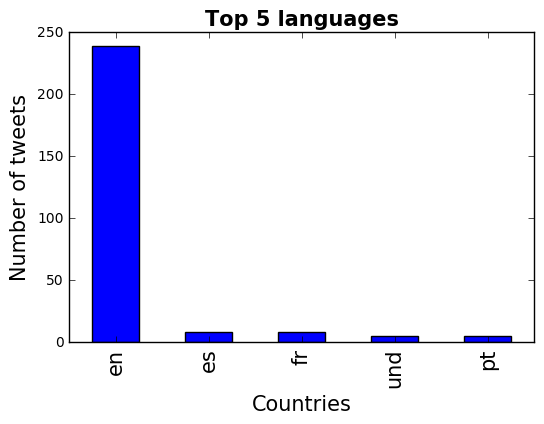

In [11]:
%matplotlib inline

tweets_by_country = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

### Part 3. Mining the tweets

Our main goals in these text mining tasks are: compare the popularity of Python, Ruby and Javascript programming languages and to retrieve programming tutorial links. We will do this in 3 steps:

1. We will add tags to our tweets DataFrame in order to be able to manipualte the data easily.
2. Target tweets that have "pogramming" or "tutorial" keywords.
3. Extract links from the relevants tweets

In [12]:
import re

def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [13]:
tweets['python'] = tweets['text'].apply(lambda tweet: word_in_text('python', tweet))
tweets['javascript'] = tweets['text'].apply(lambda tweet: word_in_text('javascript', tweet))
tweets['ruby'] = tweets['text'].apply(lambda tweet: word_in_text('ruby', tweet))

In [14]:
print tweets['python'].value_counts()[True]
print tweets['javascript'].value_counts()[True]
print tweets['ruby'].value_counts()[True]

64
61
126


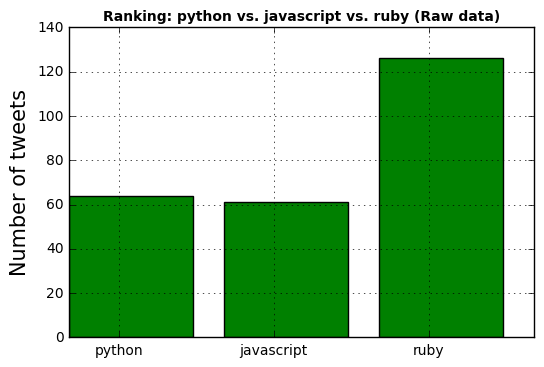

In [15]:
prg_langs = ['python', 'javascript', 'ruby']
tweets_by_prg_lang = [tweets['python'].value_counts()[True], tweets['javascript'].value_counts()[True], tweets['ruby'].value_counts()[True]]

x_pos = list(range(len(prg_langs)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_prg_lang, width, alpha=1, color='g')

# Setting axis labels and ticks
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: python vs. javascript vs. ruby (Raw data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(prg_langs)
plt.grid()

This shows, that the keyword ruby is the most popular, followed by python then javascript. However, the tweets DataFrame contains information about all tweets that contains one of the 3 keywords and doesn't restrict the information to the programming languages. For example, there are a lot tweets that contains the keyword ruby and that are related to a political scandal called Rubygate. In the next section, we will filter the tweets and re-run the analysis to make a more accurate comparison.

**Targeting relevant tweets**

We are intersted in targetting tweets that are related to programming languages. Such tweets often have one of the 2 keywords: "programming" or "tutorial". We will create 2 additional columns to our tweets DataFrame where we will add this information.

In [20]:
tweets['analysis'] = tweets['text'].apply(lambda tweet: word_in_text('analysis', tweet))
tweets['data'] = tweets['text'].apply(lambda tweet: word_in_text('data', tweet))

In [21]:
tweets['relevant'] = tweets['text'].apply(lambda tweet: word_in_text('analysis', tweet) or word_in_text('data', tweet))

In [24]:
print tweets[tweets['relevant'] == True]['python'].value_counts()
print tweets[tweets['relevant'] == True]['javascript'].value_counts()
print tweets[tweets['relevant'] == True]['ruby'].value_counts()

True     7
False    1
Name: python, dtype: int64
False    8
Name: javascript, dtype: int64
False    7
True     1
Name: ruby, dtype: int64


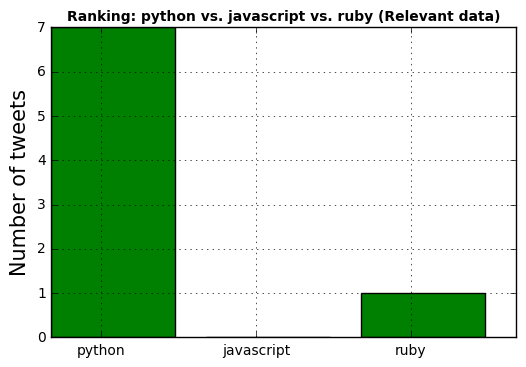

In [26]:
tweets_by_prg_lang = [tweets[tweets['relevant'] == True]['python'].value_counts()[True], 
                      0,
                      tweets[tweets['relevant'] == True]['ruby'].value_counts()[True]]
x_pos = list(range(len(prg_langs)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_prg_lang, width,alpha=1,color='g')
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: python vs. javascript vs. ruby (Relevant data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(prg_langs)
plt.grid()

**Extracting links from the relevants tweets**

Now that we extracted the relevant tweets, we want to retrieve links to programming tutorials. We will start by creating a function that uses regular expressions for retrieving link that start with "http://" or "https://" from a text. This function will return the url if found, otherwise it returns an empty string.

In [27]:
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

In [28]:
tweets['link'] = tweets['text'].apply(lambda tweet: extract_link(tweet))

In [29]:
tweets_relevant = tweets[tweets['relevant'] == True]
tweets_relevant_with_link = tweets_relevant[tweets_relevant['link'] != '']

In [30]:
print tweets_relevant_with_link[tweets_relevant_with_link['python'] == True]['link']

7      https://t.co/oTDKkoy9vr
36     https://t.co/ApULX7ArlR
151    https://t.co/sPNlvq6PGK
153    https://t.co/MH6o6Q1Tgz
197    https://t.co/jvgFK48CGb
245    https://t.co/azEhFRMg0O
Name: link, dtype: object
